- Roll no : MA24M023

- Name : Satheesh D M

This file contains only the solution for Question-1 from the assignment 1.

In [1]:
# torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


In [2]:
# random numbers - seed
import numpy as np
import random

# seed values
seed = 42  # or any number you prefer
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## MLP class

The following cell contains the definition of the MLP model and its Batch normalised version in PyTorch framework.

### Network architecture:

- 4 layers in total. (3 hidden layers + 1 output layer)

- Hidden layer activation function: ReLU
- Hidden layer sizes: 500, 250, 100
- Output layer activation function: Softmax
- Output layer size: 10

Note : In batch normalised version there is a nn.BatchNorm(1d) after each fully connected layers and couple it to the activation layers. 
### Network output - Logits


In [4]:
class MLP(nn.Module):
    # Constructor - defines model layers
    def __init__(self):
        # Call parent constructor (mandatory for pytorch compatibility)
        super(MLP, self).__init__()

        # Model layers

        # Flatten layer - converts 3D input to 1D (input processing)
        # Input: (batch_size, 32, 32, 3) --> Output: (batch_size, 3072)
        self.flatten = nn.Flatten()

        # Fully connected layer 1
        # Input: (batch_size, 3072) --> Output: (batch_size, 500)
        self.fc1 = nn.Linear(32 * 32 * 3, 500)
        # ReLU activation function
        self.relu1 = nn.ReLU()

        # Fully connected layer 2
        # Input: (batch_size, 500) --> Output: (batch_size, 250)
        self.fc2 = nn.Linear(500, 250)
        # ReLU activation function
        self.relu2 = nn.ReLU()

        # Fully connected layer 3
        # Input: (batch_size, 250) --> Output: (batch_size, 100)
        self.fc3 = nn.Linear(250, 100)
        # ReLU activation function
        self.relu3 = nn.ReLU()

        # Output layer (fully connected)
        # Input: (batch_size, 100) --> Output: (batch_size, 10)
        self.output = nn.Linear(100, 10)
        # Softmax activation function
        # dim=1 applies softmax across classes for each sample in the batch
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Forward pass
        # Argument x: input tensor to the MLP (batch_size, 3, 32, 32)

        # Input layer (flatten)
        x = self.flatten(x)  # --> (batch_size, 3072)

        # Hidden layers
        # Fully connected layer 1
        x = self.relu1(self.fc1(x))  # --> (batch_size, 500)
        # Fully connected layer 2
        x = self.relu2(self.fc2(x))  # --> (batch_size, 250)
        # Fully connected layer 3
        x = self.relu3(self.fc3(x))  # --> (batch_size, 100)

        # return value is the logits (nn.CrossEntropyLoss takes logit as input and performs softmax on it).
        return x

# Batch normalised MLP 
class MLP_BN(nn.Module):
    def __init__(self):
        super(MLP_BN, self).__init__()

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layer 1 + BatchNorm + ReLU
        self.fc1 = nn.Linear(32 * 32 * 3, 500)
        self.bn1 = nn.BatchNorm1d(500)
        self.relu1 = nn.ReLU()

        # Fully connected layer 2 + BatchNorm + ReLU
        self.fc2 = nn.Linear(500, 250)
        self.bn2 = nn.BatchNorm1d(250)
        self.relu2 = nn.ReLU()

        # Fully connected layer 3 + BatchNorm + ReLU
        self.fc3 = nn.Linear(250, 100)
        self.bn3 = nn.BatchNorm1d(100)
        self.relu3 = nn.ReLU()

        # Output layer (logits, no softmax)
        self.output = nn.Linear(100, 10)

    def forward(self, x):
        # Flatten input
        x = self.flatten(x)

        # Fully connected layers with BatchNorm and ReLU
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.relu3(self.bn3(self.fc3(x)))

        # Output layer (logits)
        return self.output(x)


## Data preprocessing and loading

This code is executed in 4 cpu cores.


In [5]:
# transform the data to tensor and normalize it
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

num_workers = 4
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=num_workers, prefetch_factor=8, persistent_workers=True)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=num_workers, prefetch_factor=8, persistent_workers=True)

## Initialising the model object, loss function and optimiser object.

- This note book contains the Batch normalised version of MLP as an example.

- Other models and experimentation is done by altering the contents of the following cell only.

In [6]:
# Model loading and other boilerplate code required to train the model
model = MLP_BN()

# Loss function and optimizer (PyTorch object initialization)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

## Helper function for training

In [7]:
def reset_model(model) -> None :
    """
    Resets the parameters of all layers in the model.
    """
    for layer in model.children():  # Iterate through each child layer of the model
        if hasattr(layer, 'reset_parameters'):  # Ensure the layer has a reset method before calling it
            layer.reset_parameters()  # Reset the layer's weights and biases
    return None

def training(model, loss_func, optimizer, trainloader, testloader, epochs=10, log_file="training_log.txt"):
    """
    Trains a given model using the specified loss function and optimizer.
    Logs training and validation metrics to a file.
    """
    # Reset model weights to ensure training starts from scratch
    reset_model(model)

    # Initialize the log file with CSV-style headers
    with open(log_file, 'w') as file:
        file.write("Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy\n")

    # Lists to track training and validation metrics over epochs
    train_losses = []
    validation_loss = []
    validation_accuracy = []
    train_accuracies = []

    # Main training loop, iterates over the number of epochs
    for epoch in range(epochs):
        running_loss = 0.0  # Accumulate loss over batches
        correct = 0  # Track the number of correct predictions
        total = 0  # Track the total number of samples

        # Training phase - update model weights
        for i, (inputs, labels) in enumerate(trainloader):
            optimizer.zero_grad()  # Zero out gradients from previous step
            outputs = model(inputs)  # Forward pass through the model
            loss = loss_func(outputs, labels)  # Compute loss
            running_loss += loss.item()  # Accumulate batch loss
            loss.backward()  # Backpropagation - compute gradients
            optimizer.step()  # Update weights using optimizer

            # Compute the number of correct predictions in the batch
            _, predicted = torch.max(outputs, dim=1)  # Get class with max score
            correct += (predicted == labels).sum().item()  # Count correct
            total += labels.size(0)  # Count total samples

        # Calculate average training loss and accuracy for the epoch
        avg_loss = running_loss / total
        accuracy = 100 * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Validation phase - evaluate model without updating weights
        validation_error = 0.0
        total_test = 0
        correct_test = 0
        with torch.no_grad():  # Disable gradient computation for validation
            for i, (inputs_test, labels_test) in enumerate(testloader):
                outputs_test = model(inputs_test)  # Forward pass
                loss_test = loss_func(outputs_test, labels_test)  # Compute loss
                validation_error += loss_test.item()  # Accumulate loss
                total_test += labels_test.size(0)  # Count total test samples

                # Calculate number of correct predictions
                _, predicted_test = torch.max(outputs_test, dim=1)
                correct_test += (predicted_test == labels_test).sum().item()

        # Calculate average validation loss and accuracy for the epoch
        val_loss = validation_error / total_test
        val_accuracy = 100 * correct_test / total_test
        validation_loss.append(val_loss)
        validation_accuracy.append(val_accuracy)

        # Log the epoch metrics to the CSV file
        with open(log_file, 'a') as file:
            file.write(f"{epoch + 1},{avg_loss:.8f},{accuracy:.2f}%,{val_loss:.8f},{val_accuracy:.2f}%\n")

        # Print the progress for real-time tracking
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {avg_loss:.8f}, Train Acc: {accuracy:.2f}%, "
              f"Val Loss: {val_loss:.8f}, Val Acc: {val_accuracy:.2f}%")

    print("Finished Training")

    # Return all tracked metrics for further analysis or plotting
    return train_losses, train_accuracies, validation_loss, validation_accuracy


## Helper function for plotting

In [9]:
def plot_loss_and_accuracy(train_loss, train_acc, valid_loss, valid_acc):
    import matplotlib.pyplot as plt  # Import Matplotlib for plotting

    # Create a 1x2 grid of subplots (for loss and accuracy)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot training and validation loss curves
    axes[0].grid(True, alpha=0.35, linestyle='-.', color='black', linewidth=0.75)  # Add gridlines for better readability
    axes[0].plot(range(1, len(train_loss) + 1), train_loss, color='red', linestyle='-', linewidth=1, marker='.', label='Training loss')
    axes[0].plot(range(1, len(valid_loss) + 1), valid_loss, color='green', linestyle='-', linewidth=1, marker='.', label='Validation loss')
    axes[0].set_title('Loss Curves', fontsize=16)  # Title of the plot
    axes[0].set_xlabel('Epochs', fontsize=12)       # X-axis label
    axes[0].set_ylabel('Average Loss over an epoch', fontsize=11)  # Y-axis label
    axes[0].legend()  # Add legend

    # Plot training and validation accuracy curves
    axes[1].grid(True, alpha=0.35, linestyle='-.', color='black', linewidth=0.75)
    axes[1].plot(range(1, len(train_acc) + 1), train_acc, color='red', linestyle='-', linewidth=1, marker='.', label='Training Accuracy')
    axes[1].plot(range(1, len(valid_acc) + 1), valid_acc, color='green', linestyle='-', linewidth=1, marker='.', label='Validation Accuracy')
    axes[1].set_title('Accuracy Curves', fontsize=16)
    axes[1].set_xlabel('Epochs', fontsize=12)
    axes[1].set_ylabel('Average Accuracy over an epoch', fontsize=11)
    axes[1].legend()

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()  # Display the plot

    return None  # Explicit return for clarity

#### Comment: The following cells demonstrates an experiment with the Batch normalized version of the MLP.

Epoch [1/60], Train Loss: 0.03087047, Train Acc: 31.72%, Val Loss: 0.02866118, Val Acc: 37.94%
Epoch [2/60], Train Loss: 0.02739893, Train Acc: 40.44%, Val Loss: 0.02680558, Val Acc: 42.11%
Epoch [3/60], Train Loss: 0.02581195, Train Acc: 43.79%, Val Loss: 0.02562371, Val Acc: 44.36%
Epoch [4/60], Train Loss: 0.02465576, Train Acc: 46.29%, Val Loss: 0.02476273, Val Acc: 46.20%
Epoch [5/60], Train Loss: 0.02370272, Train Acc: 48.28%, Val Loss: 0.02410375, Val Acc: 47.39%
Epoch [6/60], Train Loss: 0.02290732, Train Acc: 50.06%, Val Loss: 0.02359448, Val Acc: 47.80%
Epoch [7/60], Train Loss: 0.02221746, Train Acc: 51.40%, Val Loss: 0.02314934, Val Acc: 48.88%
Epoch [8/60], Train Loss: 0.02155650, Train Acc: 52.65%, Val Loss: 0.02285536, Val Acc: 49.33%
Epoch [9/60], Train Loss: 0.02097048, Train Acc: 54.33%, Val Loss: 0.02256082, Val Acc: 50.24%
Epoch [10/60], Train Loss: 0.02039666, Train Acc: 55.49%, Val Loss: 0.02238632, Val Acc: 50.41%
Epoch [11/60], Train Loss: 0.01990205, Train Acc:

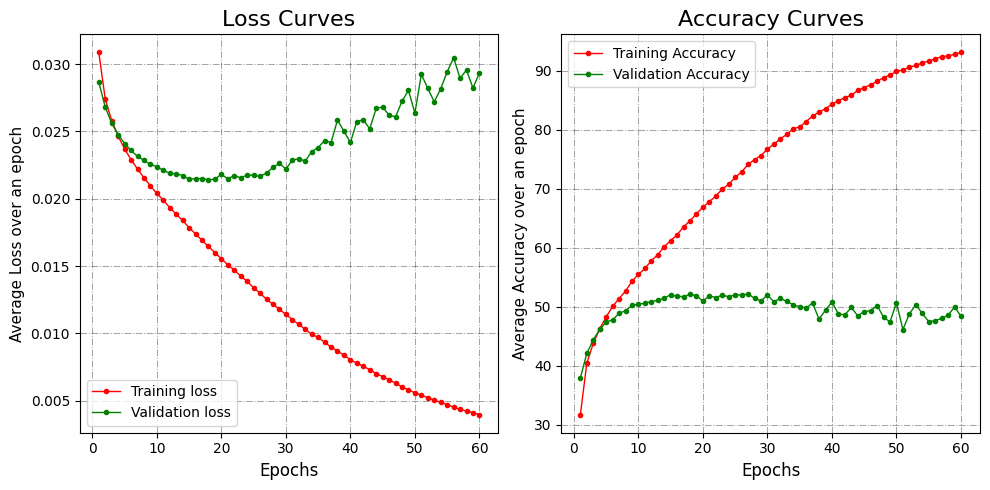

In [ ]:
# train model
t_loss, t_acc, v_loss, v_acc = training(model, loss_func, optimizer, trainloader,testloader, epochs=60)

# plots (Answer for part 1)
plot_loss_and_accuracy(t_loss, t_acc, v_loss, v_acc)

#### Comments (answer for part 2)

- The minima if the validation error curve is at the 18th epoch end.

- The accuracy at the 18th epoch's end is 52.10%
- It is not the best model. But it performs roughly 5 times better than a random guess for this problem (~10% accurate).

- The validation error on the entire data set  (over an epoch) is 0.02141829

In [11]:
# train the model till its best (18th epoch) for proceeding further.t_loss
t_loss, t_acc, v_loss, v_acc = training(model, loss_func, optimizer, trainloader,testloader, epochs=18)

Epoch [1/18], Train Loss: 0.03095745, Train Acc: 31.58%, Val Loss: 0.02871305, Val Acc: 37.71%
Epoch [2/18], Train Loss: 0.02745178, Train Acc: 40.45%, Val Loss: 0.02681421, Val Acc: 41.73%
Epoch [3/18], Train Loss: 0.02581384, Train Acc: 43.78%, Val Loss: 0.02564200, Val Acc: 44.00%
Epoch [4/18], Train Loss: 0.02458673, Train Acc: 46.35%, Val Loss: 0.02473685, Val Acc: 45.58%
Epoch [5/18], Train Loss: 0.02366553, Train Acc: 48.03%, Val Loss: 0.02404369, Val Acc: 46.88%
Epoch [6/18], Train Loss: 0.02283864, Train Acc: 49.85%, Val Loss: 0.02360308, Val Acc: 47.93%
Epoch [7/18], Train Loss: 0.02211847, Train Acc: 51.49%, Val Loss: 0.02314212, Val Acc: 48.48%
Epoch [8/18], Train Loss: 0.02148073, Train Acc: 52.89%, Val Loss: 0.02275478, Val Acc: 49.21%
Epoch [9/18], Train Loss: 0.02086126, Train Acc: 54.38%, Val Loss: 0.02259119, Val Acc: 49.59%
Epoch [10/18], Train Loss: 0.02026964, Train Acc: 55.75%, Val Loss: 0.02245899, Val Acc: 49.63%
Epoch [11/18], Train Loss: 0.01971937, Train Acc:

#### answer to part 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].


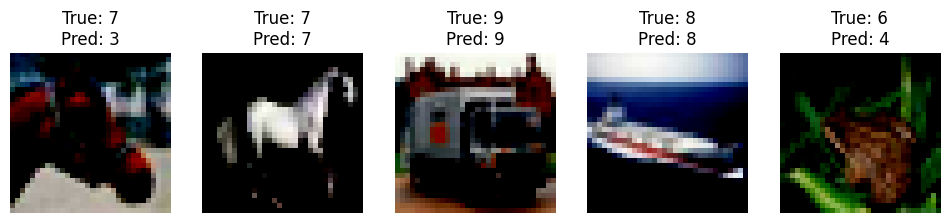

In [ ]:
import matplotlib.pyplot as plt

## Function to display random test images with true and predicted indices
def display_predictions_with_indices(model, testloader, num_images=5):
    model.eval()  # Set the model to evaluation mode
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    # Get predictions
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # Randomly select num_images to display
    indices = random.sample(range(len(images)), num_images)
    selected_images = images[indices]
    selected_labels = labels[indices]
    selected_preds = preds[indices]

    # Plot images with indices
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        img = selected_images[i].permute(1, 2, 0).cpu().numpy()  # Convert from tensor
        plt.imshow(img)
        plt.title(f'True: {selected_labels[i].item()}\nPred: {selected_preds[i].item()}')
        plt.axis('off')

    plt.show()

# Example usage
display_predictions_with_indices(model, testloader)

#### answer to part 4

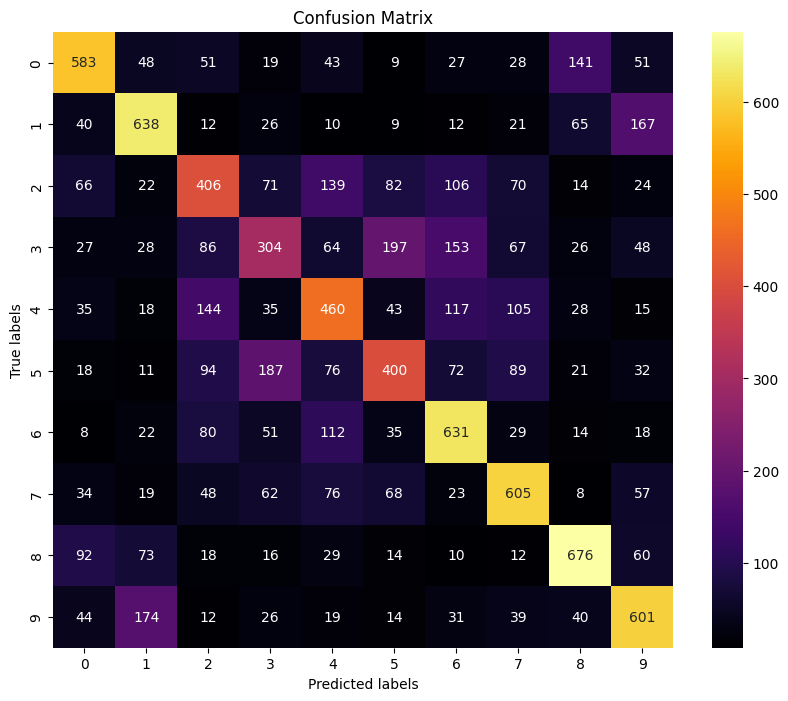

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to compute and plot the confusion matrix
def plot_confusion_matrix(model, testloader, num_classes=10):
    model.eval()  # Set the model to evaluation mode to disable dropout, batchnorm, etc.

    # Initialize lists to collect true labels and predicted labels
    all_labels = []
    all_preds = []

    # Disable gradient computation for faster evaluation
    with torch.no_grad():
        for images, labels in testloader:  # Iterate through the test data
            outputs = model(images)  # Get model predictions
            _, preds = torch.max(outputs, 1)  # Get the class with the highest probability
            all_labels.extend(labels.cpu().numpy())  # Store true labels
            all_preds.extend(preds.cpu().numpy())  # Store predicted labels

    # Compute confusion matrix using sklearn
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(10, 8))  # Set plot size
    sns.heatmap(cm, annot=True, fmt='d', cmap='inferno',  # Display values with 'inferno' colormap
                 xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted labels')  # X-axis label
    plt.ylabel('True labels')  # Y-axis label
    plt.title('Confusion Matrix')  # Title of the plot
    plt.show()  # Display the plot

    return None  # Explicitly return None


# Example usage
plot_confusion_matrix(model, testloader)

#### answer to part 5

- Batch normalization infact speeded up the converegence of the model.

- MLP without Batch normalization for the same configuration in this note book. (batch size = 64, alpha = 0.001, opt = SGD) 

- It took about 70 min to iterate through 200 epochs.
- Batch normalized version too only 13 min for the 200 epoches.
- and the test accuracy improved. 

- The following some reasons for the betterment of the results,
    
    - Internal Covariate Shift Reduction (stabilizes input layer's distribution acrss mini batches).

    - By normalizing inputs, BN makes the loss surface smoother, helping gradient descent take larger, more stable steps.
    - BN reduces exploding or vanishing gradients by keeping activations within a controlled range.
    - BN adds noise due to mini-batch statistics, acting like a form of regularization and reducing overfitting — improving test accuracy.
    - Normalized inputs allow for larger learning rates without divergence, speeding up convergence.

## Further experimentations and their summary

- All experiments were done for mini-batch size of 64 due to time constraints.

- SGD optiminzer when tuned for learning rate in log scale in MLP without BN took around 50 to 70 epochs to complete a u-turn in the valudation error.

- SGD in BN-MLP took abot 30 epoches to complete the validation curve u-turn.

- Adam optimizer was by the fastest in converging (around 10 to 15 epochs for complete u-turn).

- All best models in their respective optimizers gave a validation accuracy of 52% to 54%.

- Plots were included in the attached zip file for my above claims. (Hopefully, my naming convention is obvious).

